In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score , accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array



## Data exploration and preparation

>#### load 'A_Z Handwritten Data.csv' dataset

In [2]:
df = pd.read_csv('A_Z Handwritten Data.csv')

In [3]:
# get copy from the original to preprocess

df_pre = df.copy()


In [4]:
# get information about the dataset

display(df_pre.describe())


print("-"*80)


# to know the number of the rows
print(f"total records:",len(df), "\n")





,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
count,372450.000000,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,...,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000
mean,13.523490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001616,0.001592,0.001117,0.000929,0.000685,0.000596,0.000618,0.000690,0.000239,0.000011
std,6.740824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490788,0.517297,0.421332,0.419180,0.385566,0.319820,0.208942,0.335227,0.134852,0.006554
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,252.000000,226.000000,229.000000,228.000000,235.000000,194.000000,103.000000,198.000000,82.000000,4.000000


--------------------------------------------------------------------------------
total records: 372450 



>#### Identify the number of unique classes and show their distribution.


Unique classes and their counts:
A: 13869
B: 8668
C: 23409
D: 10134
E: 11440
F: 1163
G: 5762
H: 7218
I: 1120
J: 8493
K: 5603
L: 11586
M: 12336
N: 19010
O: 57825
P: 19341
Q: 5812
R: 11566
S: 48419
T: 22495
U: 29008
V: 4182
W: 10784
X: 6272
Y: 10859
Z: 6076
--------------------------------------------------------------------------------


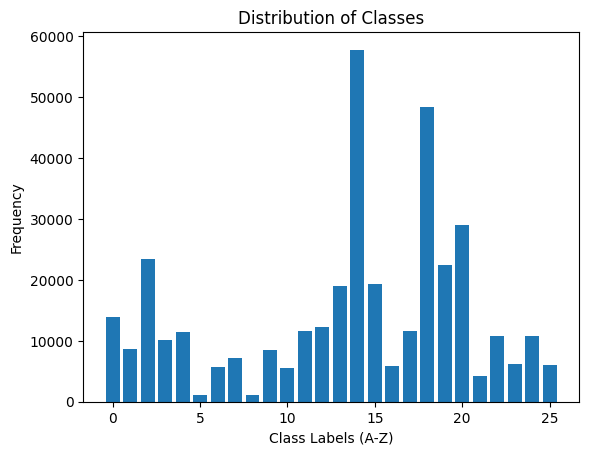

In [5]:
# We know that the fisrt column is the target 
# contains numbers from 0 to 25 (A-Z).

# Count the frequency of each letter
# df_pre["0"] to get the first column as its name is "0" from the above information
unique_classes, counts = np.unique(df_pre["0"], return_counts=True)

print("Unique classes and their counts:")
for cls, count in zip(unique_classes, counts):
    print(f"{chr(cls + ord('A'))}: {count}")
print("-" * 80)

# show the distribution
plt.bar(unique_classes, counts)
plt.title("Distribution of Classes")
plt.xlabel("Class Labels (A-Z)")
plt.ylabel("Frequency")
plt.show()


>#### Normalize each image. 


In [6]:
# Normalize images
# divide by 255 to make the data between 0 and 1
df_normalized = df_pre.astype("float32") / 255.0


>#### Reshape the flattened vectors to reconstruct and display the corresponding images while testing the models. 

In [7]:

# Separate the target column (first column)
# we get it from the original dataset not from the normalized dataset 
# iloc[Rows , Columns] , ":" means all records , "0" mean the first column 
df_targets = df_pre.iloc[:, 0].values  

# Extract the image data (columns 2 to 785) and reshape each row into 28x28
# iloc[Rows , Columns] , ":" means all records , "1:" mean the second column to the last column 
# the data already is 2d array so the "images" will be 3d array 
# as in each index will contain 2d array ( 28 X 28 ) 
# "-1" automatically calculates the number of images based on the total data size. 
# mean will return the number of rows
df_images = df_normalized.iloc[:, 1:].values.reshape(-1, 28, 28)  


print("Images shape:", df_images.shape)

print("-"*80)

# the firts image in 2d array   
print(df_images[0])


Images shape: (372450, 28, 28)
--------------------------------------------------------------------------------
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0. 

>#### Letters Visualization

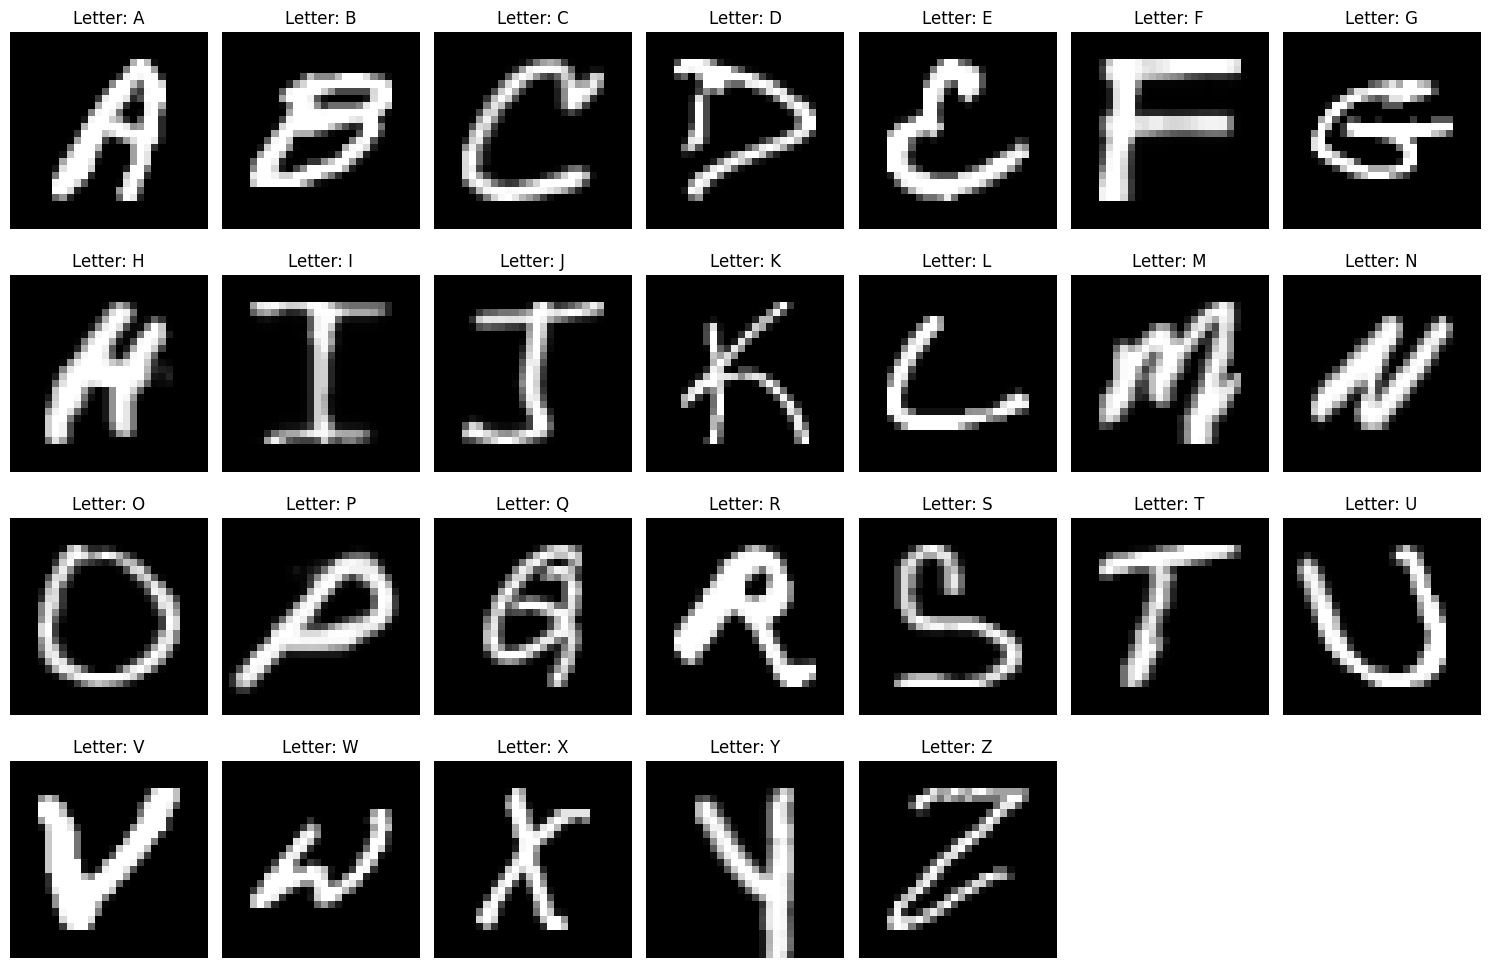

In [8]:
# we have the unique classes and its counts 
# we need cumulative sum to get index that represents each letter
# Create list from the cumulative sum as the following
# sum(count[:i]) means sum the counts from the first index to the i index
cumulative_counts = [sum(counts[:i]) for i in range(len(counts) + 1)]  


# Create a figure for displaying all letters
plt.figure(figsize=(15, 10))

# Loop through all 26 letters
for i, letter in enumerate(unique_classes):
    # Get the starting index for the current letter
    idx = cumulative_counts[i]

    # Create a grid of 4 rows and 7 columns for visualization 
    plt.subplot(4, 7, i + 1)  
    
    # Display the image using "imshow" that used to display data as an image on a 2D
    plt.imshow(df_images[idx], cmap='gray')  

    # Show the letter as character not as number
    # "ord" get the ASCII representation then add the letter number 
    # then convert to character using casting "chr"
    plt.title(f"Letter: {chr(letter + ord('A'))}") 

    # Hide axes 
    plt.axis("off")  

plt.tight_layout()
plt.show()

>#### Split the data into training and testing datasets

In [9]:

# make the 80% from the data training set and 20% from the data testing set
# random state to ensure that the split return the same data each run


# The final data will be worked on
df_images_train, df_images_test, df_targets_train, df_targets_test = train_test_split(df_images, df_targets, test_size=0.2, random_state=42) 



# Ensure that the training set and testing set contains all the unique classes

targets_train_unique_classes = np.unique(df_targets_train)

print("No. Of Unique classes in targets train : \n" ,len(targets_train_unique_classes) )
print("-"*80)

targets_test_unique_classes = np.unique(df_targets_test)

print("No. Of Unique classes in targets test : \n" ,len(targets_test_unique_classes) )
print("-"*80)



No. Of Unique classes in targets train : 
 26
--------------------------------------------------------------------------------
No. Of Unique classes in targets test : 
 26
--------------------------------------------------------------------------------


## SVM

>#### Flatten the 3D images array into 2D array.

In [10]:
X_train = df_images_train.reshape(df_images_train.shape[0], -1)
X_test = df_images_test.reshape(df_images_test.shape[0], -1)

>#### Evaluation function

In [11]:
def evaluate_model(model_name, y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)  

    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Results for {model_name} SVM:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Average F1-Score: {f1:.2f}")

    # visualization
    class_labels = [chr(i + ord('A')) for i in range(26)]
    # Plot the heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(cm, 
            annot=True,         
            fmt='g',           
            cmap='Blues',       
            xticklabels=class_labels,  
            yticklabels=class_labels)  

    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top')  
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

>#### Linear Kernel

Results for Linear SVM:
Confusion Matrix:
[[ 2596     6     4     1     8     1     3    37     0     2     7     3
     43    24     6     9     6    22     4     0    12     0     1     4
      7     0]
 [   13  1542    10     9    16     0     1     1     2     2     2     0
      1     2    18     3     2    12    28     0     1     0     1     0
      2     5]
 [    1    13  4481     3    42     0     9     0     0     2     5    24
      0     0    97     5     4    11     9     4    21     0     1     2
      8     0]
 [    1    10     0  1805     1     0     1     0     0    12     1     0
      0     2   168    19     1     0     8     0    11     0     2     0
      0     2]
 [   15    35    70     1  1946     2    12     2     0     2    16    12
      0     9     7     7     5    34    21     0     5     0     3     1
      1     8]
 [    0     0     0     1     4   211     0     0     0     0     0     0
      0     0     0     5     0     0     2     8     0     0     0  

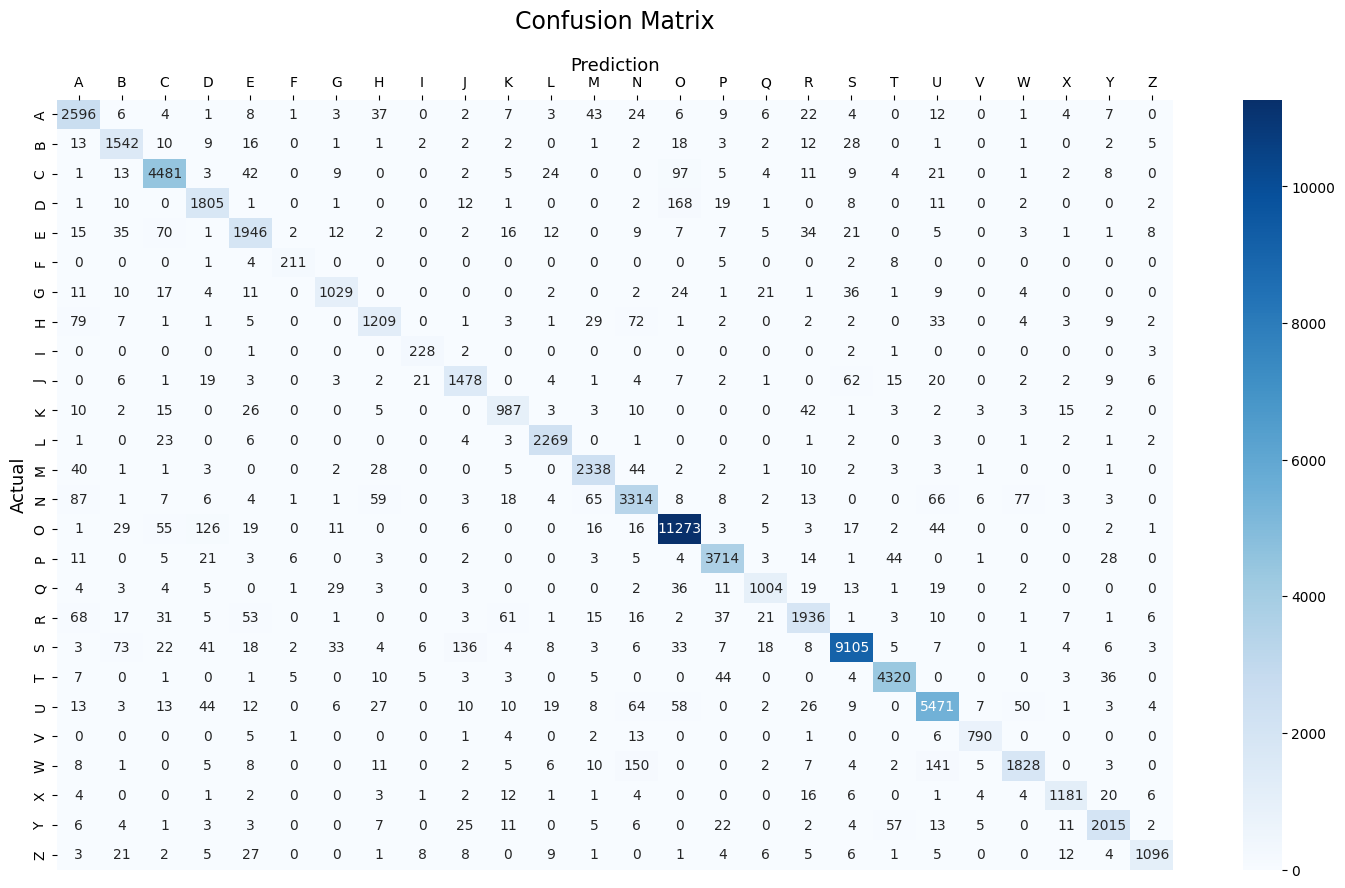

In [12]:
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(X_train, df_targets_train)
y_pred_linear = linear_svm.predict(X_test)

# Evaluate Linear Kernel
evaluate_model("Linear", df_targets_test, y_pred_linear)

>#### Nonlinear Kernel

Results for Nonlinear SVM:
Confusion Matrix:
[[ 2757     0     1     2     0     0     1     8     0     0     3     2
      4     2     3     3     2     7     0     4     3     0     1     1
      2     0]
 [    3  1631     1     6     5     0     0     0     0     0     0     0
      0     0     8     6     0     9     2     0     1     0     1     0
      0     0]
 [    1     0  4670     0     5     0     1     0     0     0     1    17
      0     0    30     1     0     2     2     1     8     0     1     0
      1     1]
 [    1     6     0  1960     0     0     0     0     0     4     0     1
      0     0    60     5     1     0     2     0     4     0     0     0
      0     0]
 [    2     2    19     1  2154     1    10     0     0     0     1     5
      0     0     3     5     0     5     1     2     2     0     1     0
      0     0]
 [    0     0     0     1     1   220     0     0     0     0     0     0
      0     0     0     3     0     0     2     3     0     0     

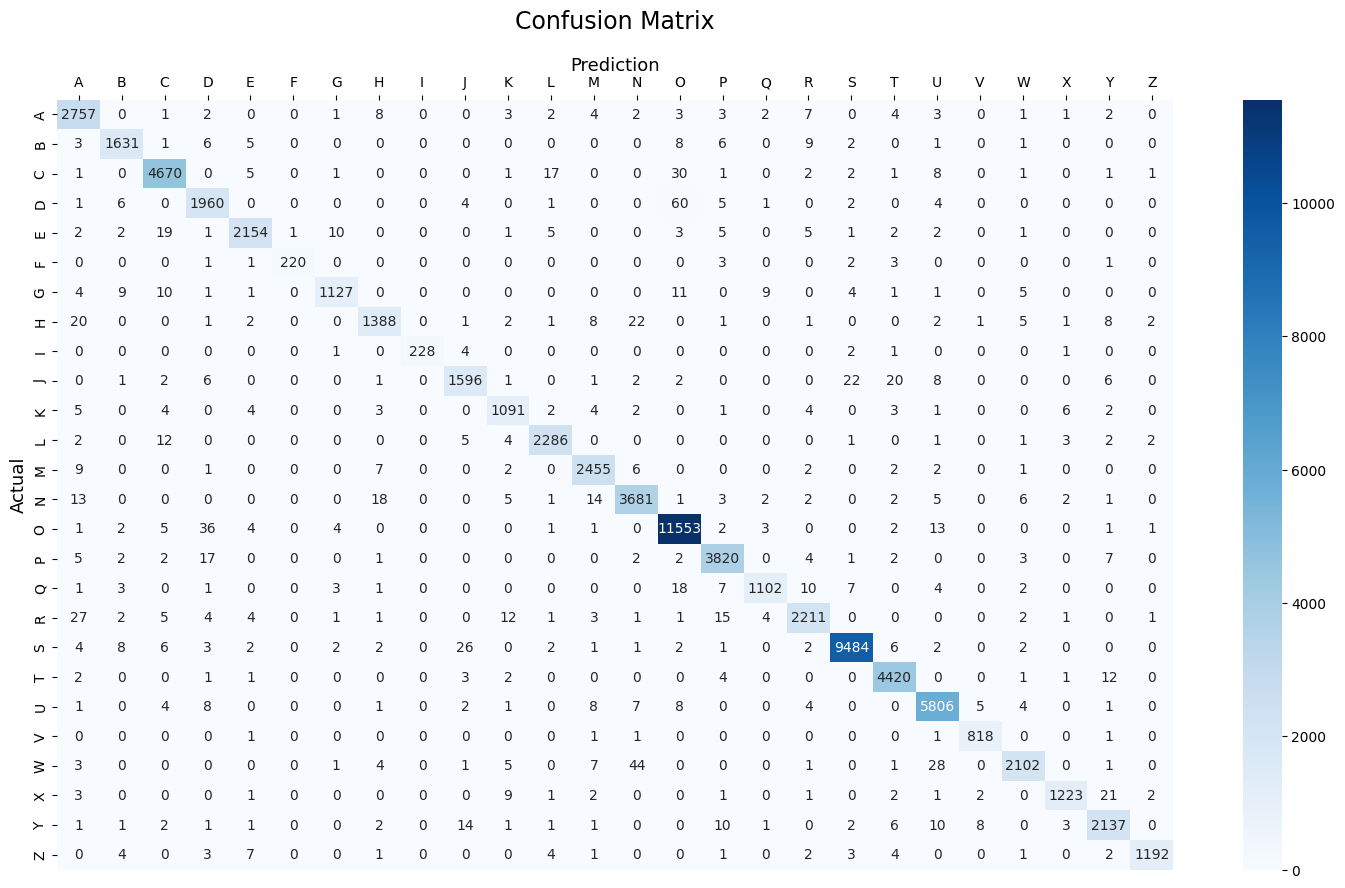

In [13]:
nonlinear_svm = SVC(kernel='rbf', random_state=42)
nonlinear_svm.fit(X_train, df_targets_train)
y_pred_nonlinear = nonlinear_svm.predict(X_test)

# Evaluate Nonlinear Kernel 
evaluate_model("Nonlinear", df_targets_test, y_pred_nonlinear)

## Logistic Regression

>#### Split the training dataset into training and validation datasets for logistic regression 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_images_train, df_targets_train, test_size=0.2, random_state=42)

>#### sigmoid function

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

>#### cost function

In [ ]:
def cost_function(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    return (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

>#### Gradient Ascent

In [ ]:

def gradient_ascent(X, y, theta, learning_rate, iterations, X_val=None, y_val=None):
    m = len(y)
    costs = []
    val_costs = []
    train_accuracies = []
    val_accuracies = []

    for i in range(iterations):
        h = sigmoid(X @ theta)
        gradient = (1 / m) * (X.T @ (y - h))  
        theta += learning_rate * gradient
        cost = cost_function(X, y, theta)
        costs.append(cost)
        
        if i % 20 == 0:
            # Calculate training accuracy
            train_pred = (h >= 0.5).astype(int)
            train_accuracy = np.mean(train_pred == y)
            train_accuracies.append(train_accuracy)

        # Track validation cost (if provided)
        if X_val is not None and y_val is not None:
            val_cost = cost_function(X_val, y_val, theta)
            val_costs.append(val_cost)
            if i % 20 == 0:
                val_h = sigmoid(X_val @ theta)
                val_pred = (val_h >= 0.5).astype(int)
                val_accuracy = np.mean(val_pred == y_val)
                val_accuracies.append(val_accuracy)

    return theta, costs, val_costs, train_accuracies, val_accuracies

>#### one vs all

In [ ]:
def one_vs_all(X, y, num_classes, learning_rate=0.01, iterations=1000, X_val=None, y_val=None):
    m, n = X.shape
    all_theta = np.zeros((num_classes, n))
    all_costs = []
    all_val_costs = []
    all_train_accuracies = []
    all_val_accuracies = []

    for c in range(num_classes):
        print(f"Training classifier for class {c}...")
        theta = np.zeros(n)
        y_binary = (y == c).astype(int)
        theta, costs, val_costs, train_accuracies, val_accuracies = gradient_ascent(X, y_binary, theta, learning_rate, iterations, X_val, y_val)
        all_theta[c] = theta
        all_costs.append(costs)
        all_val_costs.append(val_costs)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    return all_theta, all_costs, all_val_costs, all_train_accuracies, all_val_accuracies

>#### prediction function

In [ ]:

def predict(X, all_theta):
    probabilities = sigmoid(X @ all_theta.T)
    return np.argmax(probabilities, axis=1)

>#### Train the model

In [ ]:
# Flatten images for logistic regression and add intercept term
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = df_images_test.reshape(df_images_test.shape[0], -1)

# Add intercept term (bias)
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_val = np.c_[np.ones(X_val.shape[0]), X_val]

# Train the model
num_classes = len(unique_classes)
learning_rate = 0.1
iterations = 1000

print(len(X_train))
print(len(y_train))


all_theta, all_costs, val_costs, all_train_accuracies, all_val_accuracies = one_vs_all(X_train, y_train, num_classes, learning_rate, iterations, X_val, y_val)

>#### Cost curves

In [ ]:
#plot figures for the cost function and validation cost
plt.figure(figsize=(10, 6))
for c in range(num_classes):
    plt.plot(all_costs[c], label=f"Class {c}")
plt.title("Cost Function")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for c in range(num_classes):
    plt.plot(val_costs[c], label=f"Class {c}")
plt.title("Validation Cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()

>#### accuracy curves 

In [ ]:

# Plot accuracy curves
plt.figure(figsize=(10, 6))
for c in range(num_classes):
    plt.plot(all_train_accuracies[c], label=f"Class {c}")
plt.title("Training Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for c in range(num_classes):
    plt.plot(all_val_accuracies[c], label=f"Class {c}")
plt.title("Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

>#### Evaluate the model

In [ ]:
# Predict on training and testing data
y_pred_train = predict(X_train, all_theta)
y_pred_val = predict(X_val, all_theta)
y_pred_test = predict(X_test, all_theta)
print(len(all_theta))

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)


test_accuracy = accuracy_score(y_val, y_pred_val)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix and F1 scores
conf_matrix = confusion_matrix(df_targets_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

f1 = f1_score(df_targets_test, y_pred_test, average='weighted')
print(f"Average F1 Score: {f1:.2f}")

# Visualize confusion matrix
# class_labels to represent the letters from A to Z
import seaborn as sns
class_labels = [chr(i + ord('A')) for i in range(26)]


# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(conf_matrix, 
            annot=True,         
            fmt='g',           
            cmap='Blues',       
            xticklabels=class_labels,  
            yticklabels=class_labels)  

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')  
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()                


plt.show()

## Neural Networks

>#### Split the training dataset into training and validation datasets

In [ ]:
# Split the training dataset into training and validation datasets
# random state to ensure that the split return the same data each run


# The final training data will be worked on

df_images_train_final, df_images_val, df_targets_train_final, df_targets_val = train_test_split(
    df_images_train, df_targets_train, test_size=0.2, random_state=42
)

# Ensure that the final training set and validation set contain all unique classes
targets_train_final_unique_classes = np.unique(df_targets_train_final)
targets_val_unique_classes = np.unique(df_targets_val)

targets_train_unique_classes = np.unique(df_targets_train)

print("No. Of Unique classes in targets train : \n" ,len(targets_train_unique_classes) )
print("-"*80)

targets_test_unique_classes = np.unique(df_targets_test)

print("No. Of Unique classes in targets test : \n" ,len(targets_test_unique_classes) )
print("-"*80)

>#### Design 2 Neural Networks (with different number of hidden layers, neurons, activations, etc.)

In [ ]:
# first neural network model with one hidden layer 
# the first layer is flatten layer to convert the 2d array to 1d array
# the second layer is dense layer with 256 neurons and relu activation function
# the last layer is dense layer with 26 neurons(No. Of letters from A to Z) and softmax activation function

model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(26 , activation='softmax')
])


# Set the settings of the model 
# optimizer is the algorithm that will be used to minimize the loss function
# "adam" is the most popular optimizer
# loss function is the difference between the predicted value and the actual value
# "keras.losses.SparseCategoricalCrossentropy()" is used for classification problems with multiple classes
# metrics is used to evaluate the model performance 
model_a.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


# second neural network model with three hidden layers
# the first layer is flatten layer to convert the 2d array to 1d array
# the second layer is dense layer with 256 neurons and relu activation function
# the third layer is dense layer with 128 neurons and relu activation function
# the fourth layer is dense layer with 64 neurons and softplus activation function
# the last layer is dense layer with 26 neurons(No. Of letters from A to Z) and softmax activation function

model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='softplus'),
    tf.keras.layers.Dense(26 , activation='softmax')
])

model_b.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

>#### Train each one of these models and plot the error and accuracy curves for the training data and validation datasets.

In [ ]:
# Train the first model on the training data and validate on the validation data
# epochs is the number of times the model will be trained on the training data
# batch size is the number of samples that will be used in each iteration

history_a = model_a.fit(df_images_train_final, df_targets_train_final, validation_data=(df_images_val , df_targets_val),epochs=5 , batch_size=32)

# get the loss and accuracy 

loss_a = history_a.history['loss']
val_loss_a = history_a.history['val_loss']
accuracy_a = history_a.history['accuracy']
val_accuracy_a = history_a.history['val_accuracy']



# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_a, label='Training Loss')
plt.plot(val_loss_a, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_a, label='Training Accuracy')
plt.plot(val_accuracy_a, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
print("-"*80)


# train the second model on the training data and validate on the validation data
history_b =  model_b.fit(df_images_train_final, df_targets_train_final, validation_data=(df_images_val , df_targets_val),epochs=5 , batch_size=32)


loss_b = history_b.history['loss']
val_loss_b = history_b.history['val_loss']
accuracy_b = history_b.history['accuracy']
val_accuracy_b = history_b.history['val_accuracy']



# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_b, label='Training Loss')
plt.plot(val_loss_b, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_b, label='Training Accuracy')
plt.plot(val_accuracy_b, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

>#### Save the best model in a separated file

In [ ]:
# Compare the validation accuracy of both models

# uncomment the following code to compare the validation accuracy of both models and save the best


# if max(accuracy_a) > max(accuracy_b):
#     best_model = model_a
# else:
#     best_model = model_b

# # Save the best model
# best_model.save('best_model.keras')

>#### Relod the model

In [ ]:
best_model = tf.keras.models.load_model('best_model.keras')


>#### Test the best model and provide the confusion matrix and the average f-1 scores for the testing data.

In [ ]:
# Evaluate the best model on the testing data 

df_targets_predictions = best_model.predict(df_images_test)


# Get the class with the highest probability
# argmax return the index of the maximum value
# axis=1 to get the maximum value in each row
# the result will be the class label (0-25) of the letter
df_targets_predictions_classes = np.argmax(df_targets_predictions, axis=1)


# Get the confusion matrix 
cm = confusion_matrix(df_targets_test,df_targets_predictions_classes)

# class_labels to represent the letters from A to Z
class_labels = [chr(i + ord('A')) for i in range(26)]

# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(cm, 
            annot=True,         
            fmt='g',           
            cmap='Blues',       
            xticklabels=class_labels,  
            yticklabels=class_labels)  

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')  
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()                


plt.show()

>#### Provide the average f-1 scores for the testing data.


In [ ]:
# Get the classification report to get the F1-score avg
report = classification_report(df_targets_test, df_targets_predictions_classes, output_dict=True)

# get the F1-score for the 'weighted avg'
weighted_f1_score = report['weighted avg']['f1-score']

# Print the F1-score for the 'weighted avg'
print(f"Weighted Avg F1-score: {weighted_f1_score:.4f}")

>#### Test the best model with images representing the alphabetical letters for the names of each member of your team.

In [ ]:
# List of team names to test the best model
names = ['AHMED', 'SHAHD', 'SEIF', 'MARYAM']

# Initialize a dictionary to store the prediction status of unique letters
unique_letter_predictions = {}

# Test each name
for name in names:
    # To store the predicted letters of the name
    predicted_name = []  
    
    # Create a subplot for each letter
    fig, ax = plt.subplots(1, len(name), figsize=(len(name) * 2, 2))
    
    # Loop through each letter of the name
    for i, letter in enumerate(name):
        # Get the image path for each letter
        image_path = f'letters/{letter}.png'
        
        # Load the image and resize it to (28, 28) with grayscale color
        img = load_img(image_path, target_size=(28, 28), color_mode='grayscale')

        # Normalize the image
        img_array = img_to_array(img) / 255.0  

        # Reshape to (1, 28, 28)
        img_array = np.expand_dims(np.squeeze(img_array), axis=0)  
        
        # Get predictions from the model
        predictions = best_model.predict(img_array)

        # Get the class index with the highest probability
        predicted_class_index = np.argmax(predictions)  

        # Map the class index to the letter
        predicted_letter = chr(predicted_class_index + ord('A'))  
        
        # Append the predicted letter to the predicted name
        predicted_name.append(predicted_letter)
        
        # Visualize the letter
        ax[i].imshow(img_array.squeeze(), cmap='gray')
        ax[i].axis('off')  
        ax[i].set_title(predicted_letter)  

        # Track the prediction status of unique letters
        if letter not in unique_letter_predictions:
            unique_letter_predictions[letter] = (predicted_letter == letter)
    
    # Combine the predicted letters to form the full name
    predicted_full_name = ''.join(predicted_name)
    
    # Print the predicted name
    print(f"Predicted name for {name}: {predicted_full_name}")
    
    # Show the predicted name with its images
    plt.show()

# Calculate the total correct predictions and total unique letters
total_correct_predictions = sum(unique_letter_predictions.values())
total_unique_letters = len(unique_letter_predictions)

# Calculate and print the overall accuracy
accuracy =( total_correct_predictions / total_unique_letters) * 100
print(f"Overall accuracy of letter predictions: {accuracy:.2f}%")